# U - net

## Imports

In [ ]:
import cv2

import zipfile

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from PIL import Image
from tqdm import notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
#from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model


from keras.preprocessing import image
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
#from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#from tensorflow.keras.optimizers import Adam
!pip install keras-adabound
from keras_adabound import AdaBound
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-adabound: filename=keras_adabound-0.6.0-py3-none-any.whl size=6609 sha256=5ef2e76fd4484b97cc7f4a2d2cf2f779586517423fd695cbcbd1328920d74094
  Stored in directory: /root/.cache/pip/wheels/3e/bf/39/3d95847ef12aa58c15a6cc7a20f4f21ea39fcd52793e1beea0
Successfully built keras-adabound


## Get ground truth, pics and images names

In [ ]:
#define data_path & results_path

Ground truth (masks)

In [ ]:
# mat plotted
folder = data_path+'/cropped_mat'

imgs_mat = {}
for filename in os.listdir(folder):
  img = cv2.imread(os.path.join(folder,filename))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #bw
  _,thresh1 = cv2.threshold(img,175,255,cv2.THRESH_BINARY_INV) #only 0s (background, black) and 255s (whithe, signal)
  imgs_mat[filename.strip('.jpg')] = thresh1

print("No. of images = ", len(imgs_mat))

No. of images =  90


Pictures

In [ ]:
#pics - after cropping out the borders and prep

folder = data_path+'/mobile_pics'

imgs_mp = {}
for filename in os.listdir(folder):
  img = cv2.imread(os.path.join(folder,filename))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_OTSU)
  imgs_mp[filename.strip('.jpg')] = img

print("No. of images = ", len(imgs_mp))

## Set some parameters

In [ ]:
# Set some parameters
im_width = 128
im_height = 128

In [ ]:
#init datasets
X = []
y = []

## 1. Preprocess: resize images and masks

In [ ]:
#function to separate the patches of an image

def patches(img):
  h,w = img.shape

  patches =[]

  for i in range(0,h,im_height): #go vertically 128 each time
    for j in range(0,w,im_width): #go horizontally 128 each time
      patch = img[i:i+im_height,j:j+im_width]
      if patch.shape != (im_height,im_width): #in the edges (padding)
        padded_array = np.zeros((im_height, im_width))
        padded_array[:patch.shape[0],:patch.shape[1]] = patch
      patches.append(patch)

  return patches

In [ ]:
#1: preprocess

'''go image by image in the dataset and patch them and save them adequately'''
'''The mask is the ground truth label. This is what our model must predict'''

patch_id = [] #ordered list of samples ids

for n, id_ in notebook.tqdm(enumerate(ids), total=len(ids)):
  
  # Load masks (gt)
  mask = imgs_mat[id_] /255.0
  h,w = mask.shape
  pat_mask = patches(mask) #we have all patches
  

  # Load images (pics)
  x_img = imgs_mp[id_] /255.0  #imgs_cr
  x_img = resize(x_img, (h, w), mode = 'constant', preserve_range = True) #supposedly after matching they will be equal so this will not be necessary
  pat_img = patches(x_img)

  assert len(pat_mask) == len(pat_img)
  
  #  Save images
  for i in range(len(pat_img)):
    X.append(resize(pat_img[i], (im_height, im_width, 1), mode = 'constant', preserve_range = True))  #shape must be (h,w,1)
    y.append(resize(pat_mask[i], (im_height, im_width, 1), mode = 'constant', preserve_range = True))
    patch_id.append(str(i)+id_)

X = np.array(X)
y = np.array(y)

## 2. Create training and validation datasets

In [ ]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
X_t_ids, X_v_ids, y_t_ids, y_v_ids = train_test_split(patch_id, patch_id, test_size=0.1, random_state=42) #to know where everything is

In [ ]:
# Visualize any randome image along with the mask

ix = random.randint(0, len(X_train)-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix,...,0],  cmap = 'gray', interpolation = 'bilinear') 
ax1.set_title('pic')

ax2.imshow(y_train[ix].squeeze(), interpolation = 'bilinear')#cmap = 'gray', 
ax2.set_title('gt')

## 3. Set-up the model

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
# SET-UP MODEL

input_img = Input((im_height, im_width,1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

## 4. Compile

In [ ]:
optim = AdaBound( learning_rate = 1e-3, final_lr = 0.1)

model.compile(optimizer=optim, loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# model.summary()

## 5. Train

In [ ]:
checkpoint_filepath = data_path+'/tmp/checkpoint'

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath=checkpoint_filepath, verbose=1, save_best_only=True, save_weights_only=True)
]

EPOCHS = 50

In [ ]:
results = model.fit(X_train, y_train, batch_size=64, epochs=EPOCHS, callbacks=callbacks, validation_data=(X_valid, y_valid)

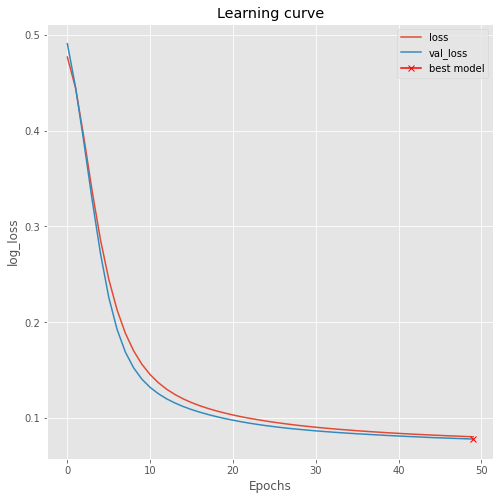

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()

## 6. Test

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].set_title('pic')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('gt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1) 
    ax[2].set_title('Predicted')

In [ ]:
# Check if training data looks all right
for i in range(20):#len(X_train)
  plot_sample(X_train, y_train, preds_train, preds_train_t, ix=i)

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=9)

## 7. Postprocess: repatch

In [ ]:
predicted_imgs = []

for id in ids:

  img_d = {}

  dat = [X_t_ids, X_v_ids]

  for c in range(len(dat)):
    for i in range(len(dat[c])):
      if id in dat[c][i]:
        idx = dat[c][i].index("A")
        img_d[dat[c][i][:idx]] = str(c)+str(i)


  h,w = imgs_mat[id].shape
  pv = int(np.ceil(h/128)) #patches vertical
  ph = int(len(img_d)/pv) #patches horizontal

  row = np.zeros((128,128*6))
  overall = np.zeros((128*4,128*6))

  n_samp = preds_train.shape[0]

  c = 0

  for i in range(4):
    for j in range(6):
      pl = img_d[str(c)]
      dat = pl[0]
      pos = int(pl[1:])
      if dat == '0':
        row[:,j*128:(j+1)*128] = preds_train[pos][:,:,-1]
      else:
        row[:,j*128:(j+1)*128] = preds_val[pos][:,:,-1]
      c+=1
    overall[i*128:(i+1)*128,:] = row

  overall = overall*255
  
  predicted_imgs.append(overall)